<a href="https://colab.research.google.com/github/NoraHK3/DataSciProject/blob/main/Data_cleaning_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **1- CSV Translation**

The original dataset contained a mix of **Arabic and English** text — some dish names and ingredients were already in English, while others were still in Arabic.
To make the data consistent and ready for analysis, this step translates **all Arabic parts** into **English**, while keeping the existing English text as it is.

It uses **Google Translate** through the `deep-translator` library, with extra tools to keep translations accurate:

* **Overrides (`overrides_expanded.json`)** – custom manual translations that replace Google’s output for specific words (e.g., “ليمون أسود” → “black lime”).
* **Cache (`translation_cache.csv`)** – stores previous translations to keep results consistent and faster.
* **Post-fixes** – fixes common translation mistakes automatically (e.g., “black lemon” → “black lime”).
* **Classification handling** – splits multi-part text like “رز | دجاج” and translates each piece separately (“rice | chicken”).

**Why we did this:**
Mixing two languages made the data inconsistent. Translating everything to English first ensures that the later cleaning and ingredient normalization steps work correctly and uniformly.

**Output:**
 `SaudiFoodFile_english_FIXED.csv` — fully English, consistent version of the dataset


In [ ]:
OVERRIDES_JSON = "overrides_expanded.json"

In [ ]:
# ============================================
# Translator (Deep) with Expanded Overrides + Cache Purge + Debug
# ============================================

!pip install -q pandas deep-translator

import os, re, json, pandas as pd
from deep_translator import GoogleTranslator

INPUT_CSV  = "SaudiFoodFile.csv"
OUTPUT_CSV = "SaudiFoodFile_english_FIXED.csv"
CACHE_CSV  = "translation_cache.csv"

# Prefer expanded overrides if present
OVR_EXP   = "overrides_expanded.json"
OVR_BASE  = "overrides.json"
OVERRIDES_JSON = OVR_EXP if os.path.exists(OVR_EXP) else OVR_BASE

HANDLE_CLASSIFICATIONS = True  # split 'classifications' by '|'
TRANSLATE_COLS = None          # None -> all object columns

# ---------- helpers ----------
AR_DIAC = re.compile(r"[\u0610-\u061A\u064B-\u065F\u06D6-\u06ED]")
def norm_ar(s: str) -> str:
    s = AR_DIAC.sub("", s)
    s = s.replace("\u0640","")
    s = s.replace("أ","ا").replace("إ","ا").replace("آ","ا")
    s = s.replace("ى","ي").replace("ئ","ي").replace("ؤ","و").replace("ٱ","ا")
    return s

def key_norm(x: str) -> str:
    return norm_ar(str(x).strip().lower())

POST_FIX = {
    "black lemon": "black lime",
    "nail": "cloves",
    "cardamon": "cardamom",
    "yougurt": "yogurt",
    "youghurt": "yogurt",
}

def apply_postfix(en: str) -> str:
    return POST_FIX.get(str(en).strip().lower(), str(en).strip())

# ---------- load data ----------
# CSV
try:
    df = pd.read_csv(INPUT_CSV, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(INPUT_CSV, encoding="cp1256")

# Overrides
if os.path.exists(OVERRIDES_JSON):
    with open(OVERRIDES_JSON, "r", encoding="utf-8") as f:
        OV = json.load(f)
else:
    OV = {}

# Normalized override view (for Arabic variant matching)
OV_NORM = {key_norm(k): v for k, v in OV.items() if re.search(r"[\u0600-\u06FF]", k)}
print(f"🔧 Using overrides file: {OVERRIDES_JSON}")
print(f"   Loaded overrides: {len(OV)} (normalized Arabic keys: {len(OV_NORM)})")
# show a few samples for sanity
for i,(k,v) in enumerate(list(OV.items())[:8]):
    print(f"   • {k}  ->  {v}")
    if i>=7: break

# Cache (load then purge entries that now have overrides)
if os.path.exists(CACHE_CSV):
    cache_df = pd.read_csv(CACHE_CSV)
    CACHE = dict(cache_df.values)  # {raw: english}
else:
    CACHE = {}

def override_lookup(text: str):
    if text in OV:
        return OV[text]
    kn = key_norm(text)
    if kn in OV_NORM:
        return OV_NORM[kn]
    return None

# Purge cache entries that should now be overridden
purged = 0
to_del = []
for raw in list(CACHE.keys()):
    if override_lookup(raw):
        to_del.append(raw)
for raw in to_del:
    CACHE.pop(raw, None)
    purged += 1
print(f"🧹 Purged {purged} cache entries that now have overrides")

translator = GoogleTranslator(source="auto", target="en")

def translate_text(text: str) -> str:
    if pd.isna(text) or str(text).strip() == "":
        return text
    s = str(text).strip()

    # 1) override wins (exact or normalized)
    ov = override_lookup(s)
    if ov:
        return ov

    # 2) cache
    if s in CACHE:
        return CACHE[s]

    # 3) machine translation
    try:
        en = translator.translate(s) or s
        en = apply_postfix(en)
    except Exception:
        en = s  # keep original on error

    CACHE[s] = en
    return en

def translate_classifications_cell(cell: str) -> str:
    parts = [p.strip() for p in str(cell).split("|")]
    out = []
    for p in parts:
        if not p:
            continue
        ov = override_lookup(p)
        en = ov if ov else translate_text(p)
        out.append(str(en).lower())
    return " | ".join(out)

# ---------- choose columns ----------
obj_cols = [c for c in df.columns if df[c].dtype == "object"]
cols = obj_cols if TRANSLATE_COLS is None else [c for c in TRANSLATE_COLS if c in df.columns]
print(f"📝 Translating columns: {cols}")

# ---------- translate ----------
for col in cols:
    print(f"➡️  Translating: {col}")
    if HANDLE_CLASSIFICATIONS and col.lower() == "classifications":
        df[col] = df[col].astype(str).apply(translate_classifications_cell)
    else:
        df[col] = df[col].apply(translate_text)

# ---------- save ----------
df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
pd.DataFrame(list(CACHE.items()), columns=["raw","english"]).to_csv(CACHE_CSV, index=False)

print(f"✅ Done: {OUTPUT_CSV}")
print(f"💾 Cache: {CACHE_CSV}")
print(f"✍️ Overrides file in use: {OVERRIDES_JSON}")

# **2- Data Cleaning**

#**Step 1: Merge Image File names and Assign Unique IDs**

**what is done**


We’re combining the Arabic and English datasets so that each English row keeps its original image file name and a new unique ID.

**Why:**

The Arabic file has the real image filenames (used later for matching or renaming images).

The English file has the cleaned and translated dish information.

Merging them lets us link each translated dish to its actual image and give every dish a clear numeric ID for easy reference in preprocessing and modeling.

**steps:**

Read both CSVs using pandas.

Find the correct “image file” column from the Arabic dataset.

Add that column into the English dataset as original names.

Create a new column image_id that numbers each row sequentially.

Save the final combined dataset as a new CSV for later steps.


**Input & Output for Step 1**



/content/SaudiFoodFile.csv → (Arabic dataset with original image filenames)

/content/SaudiFoodFile_english_FIXED.csv → (English translated dataset)

Output file:

/content/SaudiFoodFile_english_WITH_original_names_and_ID.csv → (English dataset with added original names and image_id columns)

In [ ]:
# === Extract 'image file' -> add as 'original names' -> add image_id ===
import pandas as pd

# 1) Load both files (put both CSVs in /content first)
ar_path = "/content/SaudiFoodFile.csv"
en_path = "/content/SaudiFoodFile_english_FIXED.csv"

df_ar = pd.read_csv(ar_path, encoding="utf-8-sig")
df_en = pd.read_csv(en_path, encoding="utf-8-sig")

# 2) Find the 'image file' column in the Arabic CSV (robust to spaces/underscores/case)
def find_col(cols, target="image file"):
    t = target.lower().replace("_", " ").strip()
    for c in cols:
        if c.lower().replace("_", " ").strip() == t:
            return c
    return None

image_col = find_col(df_ar.columns, "image file")
if image_col is None:
    raise KeyError(
        "Could not find a column named 'image file' in SaudiFoodFile.csv. "
        f"Available columns: {list(df_ar.columns)}"
    )

# 3) Basic sanity check (same length)
if len(df_ar) != len(df_en):
    raise ValueError(f"Row count mismatch! Arabic={len(df_ar)}, English={len(df_en)}")

# 4) Add as 'original names'
df_en["original names"] = df_ar[image_col]

# 5) Add an ID for each 'original names' row (1..N)
df_en["image_id"] = range(1, len(df_en) + 1)

# 6) Save
out_path = "/content/SaudiFoodFile_english_WITH_original_names_and_ID.csv"
df_en.to_csv(out_path, index=False, encoding="utf-8-sig")

print("✅ Done! Saved to:", out_path)
df_en.head()


#**Step 2: Remove Duplicate Rows by 'original names'**


**what is done**


We’re cleaning the dataset by removing any duplicate rows that have the same **original image name**.

**Why:**

Some images might appear more than once (for example, the same dish uploaded multiple times). Duplicates can **distort analysis and model training**, so we keep only the first occurrence of each unique image.

**steps:**

1. Load the previous cleaned CSV file.
2. Detect the **"original names"** column (even if spacing or capitalization differs).
3. Use `drop_duplicates()` to remove repeated image entries.
4. Save the new deduplicated file as **`imagesID_no_duplicates.csv`**.


Input & Output for This Step

Input file:
/content/SaudiFoodFile_english_WITH_original_names_and_ID.csv
(the file created in Step 1)

Output file:
/content/imagesID_no_duplicates.csv
(same data, but with duplicate image names removed)


In [ ]:
# === Remove Duplicate Rows by 'original names' ===
import pandas as pd

# 1) Load your CSV
df = pd.read_csv("/content/SaudiFoodFile_english_WITH_original_names_and_ID.csv", encoding="utf-8-sig")

# 2) Identify the correct column name (handles variations)
cols = [c.lower().replace("_", " ").strip() for c in df.columns]
if "original names" in cols:
    col_name = df.columns[cols.index("original names")]
else:
    raise KeyError(f"❌ Column 'original names' not found. Columns: {df.columns.tolist()}")

# 3) Drop duplicate rows based on that column (keep first)
df_clean = df.drop_duplicates(subset=[col_name], keep="first")

# 4) Save cleaned file
output_path = "/content/imagesID_no_duplicates.csv"
df_clean.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"✅ Duplicates removed successfully!")
print(f"Original rows: {len(df)}")
print(f"Cleaned rows:  {len(df_clean)}")
print(f"📁 Saved as: {output_path}")


# **Step 3: Rename ZIP Images Using CSV Mapping (Arabic-safe)**

**what is done**


Rename images inside a ZIP to the format img(ID).ext using the CSV’s original names → image_id mapping.

**Why:**


Ensures consistent, model-friendly filenames and reliable linkage between each dish row and its image.


**steps:**

(Optional) Upload CSV and ZIP via Colab widgets (or use fixed paths).

Read CSV and build a robust, Unicode-safe lookup from original names → image_id.

Iterate ZIP files; for each matched filename, write it out as img(ID).ext to the output folder.

Zip the results and write a rename report (renamed vs. skipped).


**Inputs:**

CSV: /content/imagesID_no_duplicates.csv (must contain original names and image_id)

ZIP: /content/images.zip (original images)


**Outputs:**

Folder: /content/renamed_images/ (renamed files as img(ID).ext)

ZIP: /content/renamed_images.zip (packaged renamed images)

Report CSV: /content/rename_report.csv (status for each file)

In [ ]:
# ===========================
# Rename images from ZIP using CSV (Arabic-safe)
# ===========================

# --- SETTINGS ---
USE_UPLOAD_WIDGETS = False  # True → show upload widgets for CSV + ZIP. False → use paths below.

CSV_PATH  = "/content/imagesID_no_duplicates.csv"  # used when USE_UPLOAD_WIDGETS=False
ZIP_PATH  = "/content/images.zip"                  # used when USE_UPLOAD_WIDGETS=False
OUT_DIR   = "/content/renamed_images"              # output folder
OUT_ZIP   = "/content/renamed_images.zip"          # zipped output
NAME_PREF = "img"                                  # final name format: img(ID).ext

import os, csv, zipfile, shutil, unicodedata, io
from pathlib import Path
import pandas as pd

# ---- (A) Upload files interactively in Colab (optional) ----
if USE_UPLOAD_WIDGETS:
    try:
        from google.colab import files
        print("📤 Please upload your CSV (with 'original names' + 'image_id'):")
        up1 = files.upload()
        CSV_PATH = "/content/" + list(up1.keys())[0]
        print("📤 Please upload your IMAGES ZIP:")
        up2 = files.upload()
        ZIP_PATH = "/content/" + list(up2.keys())[0]
    except Exception as e:
        raise RuntimeError("Colab file upload failed. Set USE_UPLOAD_WIDGETS=False to use paths.") from e

print("CSV_PATH:", CSV_PATH)
print("ZIP_PATH:", ZIP_PATH)

# ---- Helpers ----
def norm_header(s: str) -> str:
    return s.lower().replace("_", " ").strip()

def norm_key(name: str) -> str:
    """
    Normalize a filename for robust matching:
    - keep only basename (drop any 'images/...').
    - NFC Unicode normalization for Arabic.
    - casefold() for case-insensitive match.
    - strip spaces.
    """
    base = Path(str(name)).name
    return unicodedata.normalize("NFC", base).casefold().strip()

# ---- 1) Load mapping CSV (Arabic-safe) ----
df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")
col_map = {norm_header(c): c for c in df.columns}

# find columns
if "original names" not in col_map:
    # try common variants
    for alt in ["original name", "image file", "image", "images", "original_images"]:
        if alt in col_map:
            col_map["original names"] = col_map[alt]
            break

id_col_key = "image id" if "image id" in col_map else ("image_id" if "image_id" in col_map else None)
if "original names" not in col_map or id_col_key is None:
    raise KeyError(f"CSV must have 'original names' and 'image_id' columns. Found: {list(df.columns)}")

orig_col = col_map["original names"]
id_col   = col_map[id_col_key]

# Build lookup: normalized basename → image_id (int)
lookup = {}
dups = df[orig_col].duplicated(keep=False)
if dups.any():
    print("⚠️ CSV contains duplicate values in 'original names'. First occurrence will be used.")

for _, row in df.iterrows():
    key = norm_key(row[orig_col])
    # keep first occurrence
    if key not in lookup:
        lookup[key] = int(row[id_col])

print(f"✅ Mapping loaded: {len(lookup)} names → IDs")

# ---- 2) Prepare output dir ----
shutil.rmtree(OUT_DIR, ignore_errors=True)
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# ---- 3) Read ZIP and rename files ----
renamed, skipped = [], []

def write_member_to(path_out, zin, zinfo):
    with zin.open(zinfo) as src, open(path_out, "wb") as dst:
        dst.write(src.read())

with zipfile.ZipFile(ZIP_PATH, "r") as zin:
    for zinfo in zin.infolist():
        if zinfo.is_dir():
            continue

        # Get the basename (ignore any folders inside the zip)
        orig_zip_path = zinfo.filename
        base = Path(orig_zip_path).name
        key  = norm_key(base)

        if key in lookup:
            img_id = lookup[key]
            ext = Path(base).suffix  # keep original extension
            new_name = f"{NAME_PREF}({img_id}){ext}"
            out_path = os.path.join(OUT_DIR, new_name)
            write_member_to(out_path, zin, zinfo)
            renamed.append((orig_zip_path, new_name, img_id))
        else:
            skipped.append((orig_zip_path, "no match for 'original names'"))

# ---- 4) Zip the output folder ----
shutil.make_archive(OUT_ZIP.replace(".zip", ""), "zip", OUT_DIR)

# ---- 5) Report CSV ----
report_path = "/content/rename_report.csv"
with open(report_path, "w", newline="", encoding="utf-8-sig") as f:
    w = csv.writer(f)
    w.writerow(["status", "zip_original_path", "new_name_or_reason", "image_id"])
    for o, n, i in renamed:
        w.writerow(["renamed", o, n, i])
    for o, reason in skipped:
        w.writerow(["skipped", o, reason, ""])

print("🎉 Done!")
print(f"• Renamed: {len(renamed)}")
print(f"• Skipped (no match): {len(skipped)}")
print(f"📂 Output folder: {OUT_DIR}")
print(f"🗜️ Output zip:    {OUT_ZIP}")
print(f"🧾 Report CSV:    {report_path}")

#**Step 4: Update Image Filenames Inside the CSV**

**what is done**


Rename the image file entries inside the CSV so they match the renamed image format img(ID).ext.


**Why:**
To keep the dataset consistent with the renamed images in your folder/ZIP — ensuring every row’s filename matches its actual image file.


**steps:**

Load the latest CSV containing image_id.

Automatically find the column that holds image filenames.

Replace each filename with the new standardized format img(ID).ext while keeping the same extension.

Save the updated CSV for use in later steps.



**Input file:**
/content/imagesID_no_duplicates.csv (before renaming inside CSV)

**Output file:**
/content/imagesID_renamed_in_csv.csv (filenames now follow the img(ID).ext format)

In [ ]:
# === Rename filenames in CSV to match img(ID).ext format ===
import pandas as pd
from pathlib import Path

# 1) Load your CSV (make sure it contains 'image_id' and the column with the image file paths)
CSV_PATH = "/content/imagesID_no_duplicates.csv"  # or your latest version
df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")

# 2) Identify the image path column (commonly 'image_file' or 'images')
def find_col(cols, target="image"):
    t = target.lower()
    for c in cols:
        if t in c.lower():
            return c
    return None

img_col = find_col(df.columns, "image")
if not img_col:
    raise KeyError(f"No column found containing 'image'. Columns: {df.columns.tolist()}")

# 3) Rename each image according to its ID, keeping the same file extension
def make_new_name(old_path, image_id):
    ext = Path(str(old_path)).suffix or ".jpg"  # default to .jpg if missing
    return f"img({image_id}){ext}"

df[img_col] = [make_new_name(df.loc[i, img_col], df.loc[i, "image_id"]) for i in range(len(df))]

# 4) Save the updated CSV
OUTPUT_PATH = "/content/imagesID_renamed_in_csv.csv"
df.to_csv(OUTPUT_PATH, index=False, encoding="utf-8-sig")

print("✅ All image filenames updated inside the CSV.")
print(f"📁 Saved as: {OUTPUT_PATH}")
df.head()


#**Step 5: Remove the “original names” Column**


Delete the **`original names`** column from the dataset.

**Why:**
After all images have been renamed and matched using IDs, the original filenames are no longer needed.
Removing this column keeps the dataset **clean and ready for modeling or analysis**.

**steps**

1. Load the latest CSV file.
2. Find and drop the **`original names`** column (handles different spellings or spacing).
3. Save the final cleaned version.



**Input file:**
`/content/imagesID_renamed_in_csv.csv`

**Output file:**
`/content/remove_original_names.csv` *(final cleaned dataset without the old image name column)*


In [ ]:
# === Remove "original names" column ===
import pandas as pd

# 1) Load your CSV file
df = pd.read_csv("/content/imagesID_renamed_in_csv.csv", encoding="utf-8-sig")

# 2) Remove the column safely (handles naming variations)
cols = [c.lower().replace("_", " ").strip() for c in df.columns]
if "original names" in cols:
    col_name = df.columns[cols.index("original names")]
    df = df.drop(columns=[col_name])
else:
    raise KeyError(f"Column 'original names' not found. Columns: {df.columns.tolist()}")

# 3) Save the new file
output_path = "/content/remove_original_names.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print("✅ 'original names' column removed.")
print(f"📁 Clean file saved as: {output_path}")


#**Step 6: Clean and Standardize Dish Names**

**what is done**

This step cleans and unifies all dish names — keeping authentic Arabic and Middle Eastern dishes intact while removing unnecessary English words, event mentions, and quantity descriptions.

**Why:**
To make the dataset consistent and ready for analysis by:

Removing irrelevant phrases like “How to make” or “for Saudi National Day”.

Avoiding over-cleaning that might erase Arabic or culturally important dish names.

Standardizing different spellings (e.g., kbsa, kabsah → Kabsa) into one consistent form.

**steps:**

Load the latest dataset (remove_original_names.csv).

Use clean_dish_name() to strip only specific English words, numbers, and phrases — preserving Arabic names.

Use standardize_dish_name() to unify variations and detect dish types and proteins (e.g., Kabsa Chicken).

Display before/after examples of cleaned names.

Save the cleaned and standardized dataset as SaudiFoodFile_cc.csv.

**Input file:**
remove_original_names.csv

**Output file:**
SaudiFoodFile_cleaned_dishName.csv (final dataset with standardized and culturally accurate dish names)

In [ ]:
import pandas as pd
import numpy as np
import re

# Load the data
df = pd.read_csv('remove_original_names.csv')

# Display initial data info
print("Initial data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Task 1: Clean dish names - remove descriptions, quantities, and non-ingredient information
def clean_dish_name(name):
    """
    Remove descriptions, quantities, and non-ingredient information from dish names
    while preserving authentic Arabic/Middle Eastern dish names
    """
    # Common patterns to remove (ONLY specific English descriptions)
    patterns_to_remove = [
        # Occasions and events (English)
        r'\bfor saudi national day\b',
        r'\bfor hosting\b',
        r'\bsummer offer\b',

        # Cooking methods and styles (English)
        r'\bhow to make\b',
        r'\bhow to boil\b',
        r'\bsaudi style\b',
        r'\bhijazi style\b',
        r'\btraditional\b',
        r'\bauthentic\b',
        r'\beasy\b',
        r'\bcopycat recipe\b',
        r'\bslow-?roast\b',
        r'\bno bake\b',
        r'\brussian style\b',
        r'\brussian\b',

        # Remove ALL parentheses and their content
        r'\([^)]*\)',

        # Very specific quantity descriptions only
        r'\bwhole grain\b',
        r'\bhalf a piece\b',
        r'\bhalf piece\b',
        r'\bone person\b',

        # General English descriptions (be very specific)
        r'\bmethod for\b',
        r'\baccording to\b',
        r'\bway\b',
        r'\brecipe\b',
    ]

    cleaned_name = name.strip()

    # Remove only very specific patterns
    for pattern in patterns_to_remove:
        cleaned_name = re.sub(pattern, '', cleaned_name, flags=re.IGNORECASE)

    # Clean up extra spaces and punctuation carefully
    cleaned_name = re.sub(r'\s+', ' ', cleaned_name)
    cleaned_name = cleaned_name.strip()

    return cleaned_name

# Task 2: Standardize dish name variations to consistent naming
def standardize_dish_name(name):
    """
    Standardize variations of dish names to consistent naming conventions
    while preserving the main dish identity
    """
    if not name or name.strip() == '':
        return 'Unclassified Dish'

    # First, extract the main dish components
    name_lower = name.lower()

    # Identify the main dish type
    main_dish = None
    protein = None

    # Check for main dishes (preserve Arabic names)
    dish_patterns = {
        'Kabsa': r'\bkabsa\b|\bkabsah\b|\bkbsa\b',
        'Mandi': r'\bmandi\b',
        'Madhbi': r'\bmadhbi\b',
        'Madfoon': r'\bmadfoon\b',
        'Madghut': r'\bmadghog\b|\bmadjoun\b|\bmadjoon\b',
        'Shakshuka': r'\bshakshuka\b|\bshaksuka\b',
        'Jareesh': r'\bjareesh\b|\bjarish\b|\bgroats\b',
        'Maqluba': r'\bmaqluba\b|\bmakloubeh\b|\bmagloba\b',
        'Kleja': r'\bkleija\b|\bkleja\b|\bklija\b',
        'Maamoul': r'\bmaamoul\b|\bmamoul\b',
        'Mutabak': r'\bmutabbaq\b|\bmutabak\b',
        'Sambusa': r'\bsambosa\b|\bsambousek\b|\bsamosa\b',
        'Basbousa': r'\bbasbousa\b|\bbasbosa\b',
        'Kunafa': r'\bkunafa\b|\bknafeh\b',
        'Mulukhiyah': r'\bmulukhiyah\b|\bmolokhia\b|\bmolokhiya\b',
        'Saleek': r'\bsaleek\b|\bsaleeq\b|\bsuliq\b|\bsulait\b',
        'Freekeh': r'\bfreekeh\b|\bfreekey\b',
        'Mujaddara': r'\bmujadara\b|\bmujaddara\b',
        'Luqaimat': r'\bluqaimat\b|\bluqaymat\b',
        'Harees': r'\bharees\b|\bhareeseh\b',
        'Thareed': r'\bthareed\b|\btharid\b',
    }

    for dish, pattern in dish_patterns.items():
        if re.search(pattern, name_lower):
            main_dish = dish
            break

    # If no specific dish found, try to identify by main components
    if not main_dish:
        # Check for proteins
        if re.search(r'\bchicken\b', name_lower):
            protein = 'Chicken'
        elif re.search(r'\blamb\b', name_lower):
            protein = 'Lamb'
        elif re.search(r'\bmeat\b|\bbeef\b', name_lower):
            protein = 'Meat'
        elif re.search(r'\bfish\b', name_lower):
            protein = 'Fish'
        elif re.search(r'\bshrimp\b', name_lower):
            protein = 'Shrimp'
        elif re.search(r'\bcamel\b', name_lower):
            protein = 'Camel'

    # Build standardized name
    if main_dish:
        if protein:
            standardized_name = f"{main_dish} {protein}"
        else:
            standardized_name = main_dish
    elif protein:
        # If we only have protein but no specific dish, use the cleaned name
        standardized_name = name.title()
    else:
        # For names without clear dish type, clean but preserve the name
        standardized_name = name.title()

        # Apply gentle standardization for common variations
        variations = {
            r'\bkabsah\b': 'Kabsa',
            r'\bkbsa\b': 'Kabsa',
            r'\bmandi\b': 'Mandi',
            r'\bmutabbaq\b': 'Mutabak',
            r'\bsambosa\b': 'Sambusa',
            r'\bmaamoul\b': 'Maamoul',
            r'\bkunafa\b': 'Kunafa',
            r'\bbasbousa\b': 'Basbousa',
        }

        for pattern, replacement in variations.items():
            standardized_name = re.sub(pattern, replacement, standardized_name, flags=re.IGNORECASE)

    return standardized_name.strip()

# Apply cleaning and standardization
print("\nApplying data cleaning...")

# Create cleaned dish names
df['cleaned_dish_name'] = df['dish_name'].apply(clean_dish_name)
df['standardized_dish_name'] = df['cleaned_dish_name'].apply(standardize_dish_name)

# Show before and after examples - focus on problem cases
print("\nName cleaning examples (focusing on problem cases):")
problem_cases = [
    "A quarter of mandi chicken",
    "Quarter goat",
    "Chicken kabsa with rice",
    "Meat kabsa and daqoos salad",
    "Saudi meat kabsa and daqoos salad",
    "How to make Saudi kleija",
    "Saudi style chicken kabsa",
    "Russian style borscht soup",
    "Chicken Kabsa (curry) with rice",
    "Plain mandi rice"
]

for i, row in df.iterrows():
    if any(case.lower() in row['dish_name'].lower() for case in problem_cases):
        print(f"Original: {row['dish_name']}")
        print(f"Cleaned: {row['cleaned_dish_name']}")
        print(f"Standardized: {row['standardized_dish_name']}")
        print("-" * 50)

# Show most common dish names after standardization
print("\nMost common standardized dish names:")
print(df['standardized_dish_name'].value_counts().head(20))

# Save the cleaned data
df_cleaned = df.copy()
# Keep original name and use standardized as main dish name
df_cleaned['dish_name_original'] = df['dish_name']
df_cleaned['dish_name'] = df['standardized_dish_name']

# Drop temporary columns
df_cleaned = df_cleaned.drop(['cleaned_dish_name', 'standardized_dish_name'], axis=1)

print(f"\nFinal data shape: {df_cleaned.shape}")
print("\nFirst few rows of cleaned data:")
print(df_cleaned[['dish_name_original', 'dish_name']].head(20))

# Save to new CSV file
output_filename = 'SaudiFoodFile_cleaned_dishName.csv'
df_cleaned.to_csv(output_filename, index=False)
print(f"\nCleaned data saved to: {output_filename}")

# Additional analysis: Show name standardization results
print("\n" + "="*80)
print("NAME STANDARDIZATION SUMMARY")
print("="*80)

# Show specific problem cases and their resolution
print("\nSpecific problem cases and their resolution:")
test_cases = [
    "A quarter of mandi chicken",
    "Quarter goat",
    "Chicken kabsa with rice",
    "Saudi meat kabsa and daqoos salad",
    "How to make Saudi kleija",
    "Saudi style chicken kabsa",
    "Plain mandi rice",
    "Half grilled chicken with rice",
    "Russian style borscht soup",
    "Chicken Kabsa (curry) with rice",
    "Mandi Chicken (whole grain)",
    "Grilled chicken (half a piece)"
]

for case in test_cases:
    cleaned = clean_dish_name(case)
    standardized = standardize_dish_name(cleaned)
    print(f"Original: '{case}'")
    print(f"Cleaned: '{cleaned}'")
    print(f"Standardized: '{standardized}'")
    print("-" * 40)

# Show reduction in unique names
original_unique = df['dish_name'].nunique()
cleaned_unique = df_cleaned['dish_name'].nunique()
print(f"\nUnique name reduction: {original_unique} → {cleaned_unique} ({(1-cleaned_unique/original_unique)*100:.1f}% reduction)")

print("\nCleaning complete! Arabic dish names are preserved while English descriptions are removed.")

#**Step 7: Clean and Standardize Ingredients**


This step cleans and standardizes all ingredient information before the consistency check.
Some dishes originally had messy or incomplete ingredient lists — for example:

> `"olive oil / tomatoes - onion, chilli"` or sometimes just `"unknown"`

The goal here is to convert everything into clear, structured ingredient lists such as:

> `["olive oil", "tomato", "onion", "chili"]`
> and to replace unclear or missing entries like `["unknown"]` with the clear label `["unknown_ingredients"]`.

**What this step does:**

1. **Splits ingredients correctly:**
   Separates text using real separators (`|`, `/`, `,`, `;`, Arabic commas, or dashes) without breaking multi-word names.

2. **Protects multi-word ingredients:**
   Keeps terms like *olive oil* or *tomato paste* together as one ingredient.

3. **Removes non-ingredient words:**
   Drops extra words such as *add*, *garnish*, *with*, or *hot* that aren’t actual ingredients.

4. **Normalizes plurals and spellings:**
   Converts plurals (*tomatoes → tomato*) and unifies spellings (*chilli*, *chilies* → *chili*).

5. **Handles unknown or missing entries:**
   Any ingredient cell that is empty or simply says `"not found"` or `"unknown"` becomes `["unknown"]` to keep the format consistent.

6. **Embedding + Clustering (semantic cleaning):**
   group similar ingredient names (like *cardamon* and *cardamom*) into one canonical form.

7. **Creates standardized ingredient lists:**
   Every dish ends up with a clean list of consistent, machine-readable ingredients.

**Outputs:**

* `SaudiFoodFile_standardized.csv` → the final cleaned ingredient lists per dish. will be used in the next step.
* `ingredient_clusters_report.csv` → groups of similar ingredients and their canonical names (helper)
* `ingredient_canonical_map.json` → mapping of each ingredient to its canonical form (helper)


In [ ]:

# ============================================================
#  — Ingredient Cleaning
# - Split on real separators only (| / \ , ; ، - with spaces, bullets)
# - Protect multi-word ingredient phrases (KEEP_PHRASES)
# - Extract ingredients from stray sentences; drop non-ingredient words
# - Canonicalize with ALIASES + singularization + fuzzy nudge
# - Output only: dish_name | classifications_std_list | image_file | scrape_date
# ============================================================

!pip install -q pandas sentence-transformers scikit-learn rapidfuzz inflect

import re, json, pandas as pd
from collections import Counter, defaultdict
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from rapidfuzz import process, fuzz
import inflect

# --- Unknown/placeholder detection ---
UNKNOWN_PATTERNS = [
    r"^\s*not\s*found\s*$",
    r"^\s*unknown\s*$",
    r"^\s*n/?a\s*$",
    r"^\s*none\s*$",
    r"^\s*null\s*$",
    r"^\s*missing\s*$",
    r"^\s*بدون\s*$",           # Arabic: without
    r"^\s*غير\s*متوفر\s*$",   # Arabic: unavailable
]

UNKNOWN_REGEXES = [re.compile(p, re.IGNORECASE) for p in UNKNOWN_PATTERNS]

def is_unknown_text(s: str) -> bool:
    return any(rx.match(s) for rx in UNKNOWN_REGEXES)


# ----------------------------
# Config
# ----------------------------
INPUT_CSV  = "SaudiFoodFile_cleaned_dishName.csv"
OUTPUT_CSV = "SaudiFoodFile_standardized.csv"
REPORT_CSV = "ingredient_clusters_report.csv"
MAP_JSON   = "ingredient_canonical_map.json"

CLASS_COL_CANDIDATES = ["classifications", "classifications_en", "classfications"]
MODEL_NAME = "sentence-transformers/paraphrase-MiniLM-L6-v2"
DISTANCE_THRESHOLD = 0.35
FUZZY_SCORE_CUTOFF = 92

# ----------------------------
# Phrase protection & vocabulary
# ----------------------------
# Multi-word ingredients to KEEP as single tokens
KEEP_PHRASES = {
    # oils / dairy
    "olive oil", "vegetable oil", "clarified butter", "milk powder", "butter milk", "heavy cream",
    # stocks / sauces / pastes
    "tomato paste", "tomato sauce", "soy sauce", "pomegranate molasses", "date molasses", "rose water", "orange blossom water",
    # veg & herbs
    "bell pepper", "green onion", "spring onion", "bay leaves", "mint leaves", "parsley leaves", "coriander leaves",
    # spices
    "black lime", "mixed spices", "spice mix", "allspice", "black pepper", "white pepper",
    # proteins / grains
    "basmati rice", "chicken stock", "beef stock", "vegetable stock",
}

# Synonyms/variants → canonical (lowercase)
ALIASES = {
    # souring / lime
    "dried lime": "black lime", "dried limes": "black lime", "omani lime": "black lime",
    "omani limes": "black lime", "loomi": "black lime", "black lemon": "black lime",

    # oils/fats/dairy
    "veg oil": "vegetable oil", "olive oils": "olive oil", "butter milk": "buttermilk",
    "yoghurt": "yogurt", "labnah": "labneh",

    # herbs & veg
    "cilantro": "coriander", "coriander leaves": "coriander", "green coriander": "coriander",
    "parsley leaves": "parsley", "mint leaves": "mint", "spring onion": "green onion",

    # peppers
    "capsicum": "bell pepper", "green pepper": "bell pepper", "sweet pepper": "bell pepper",
    "chilli": "chili", "chilies": "chili", "chillies": "chili", "chili pepper": "chili", "chili peppers": "chili",

    # powders & sticks -> base spice
    "turmeric powder": "turmeric", "ginger powder": "ginger",
    "garlic powder": "garlic", "onion powder": "onion",
    "cinnamon stick": "cinnamon", "cinnamon sticks": "cinnamon",
    "cardamon": "cardamom",

    # sauces/pastes/syrups
    "tomato purée": "tomato paste", "tomato puree": "tomato paste",
    "simple syrup": "sugar syrup",

    # pulses/grains
    "garbanzo beans": "chickpeas", "garbanzo bean": "chickpeas",
    "chick peas": "chickpeas", "chick pea": "chickpeas",
    "black eyed beans": "black-eyed beans", "black eyed pea": "black-eyed beans",

    # spice mixes / generic
    "spice mix": "mixed spices", "mix spices": "mixed spices", "spices mix": "mixed spices"
}

# Words that are NOT ingredients (filler, verbs, instructions)
NON_ING_WORDS = {
    "after","decorate","decoration","decorations","add","with","such","touch","patriotic","cream",
    "or","and","the","a","an","then","until","when","like","as","to","for","of","into","over",
    "warm","hot","cold","slice","sliced","diced","chopped","minced","ground","crushed","whole",
    "fresh","optional","needed","garnish","make","prepare","preparation","cook","cooked","baked",
    "boiled","fried","seauted","sauteed","browned","mix","mixed","topping","kitchen","precise","instant"
}

# ----------------------------
# Helpers
# ----------------------------
SEP_NORMALIZER = re.compile(r"[|/\\،;,]+")      # | / \ , ; Arabic comma
AROUND_HYPHEN  = re.compile(r"\s*[-–—]\s*")     # spaced hyphens/dashes as separators
BULLETS        = re.compile(r"[•·]+")

# After splitting, strip these inside tokens
PUNCT_DROP_INSIDE = re.compile(r"[-_/\\|]+")
NONWORD           = re.compile(r"[^\w\s\(\)]")

IRREGULAR = {"tomatoes":"tomato","potatoes":"potato","limes":"lime","chillies":"chili","chilies":"chili","cloves":"cloves"}
p = inflect.engine()

def safe_str(x):
    if x is None: return ""
    s = str(x)
    return "" if s.strip().lower() in {"", "nan", "none", "null"} else s

def protect_phrases(text: str) -> str:
    """Replace spaces inside KEEP_PHRASES with underscores to protect them."""
    s = text
    # longer phrases first to avoid partial overlaps
    for ph in sorted(KEEP_PHRASES, key=lambda x: -len(x)):
        pattern = r"\b" + re.escape(ph) + r"\b"
        s = re.sub(pattern, ph.replace(" ", "_"), s, flags=re.IGNORECASE)
    return s

def normalize_separators(s: str) -> str:
    s = BULLETS.sub("|", s)
    s = AROUND_HYPHEN.sub("|", s)           # ' - ' → '|'
    s = SEP_NORMALIZER.sub("|", s)          # unify to '|'
    s = re.sub(r"\|{2,}", "|", s).strip("| ")
    return s

def to_singular(word: str) -> str:
    w = word.strip().lower()
    if w in IRREGULAR: return IRREGULAR[w]
    s = p.singular_noun(w)
    return s if isinstance(s, str) and s else w

def clean_phrase(s: str) -> str:
    s = s.strip().lower()
    s = PUNCT_DROP_INSIDE.sub(" ", s)
    s = NONWORD.sub(" ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def drop_non_ingredients(words):
    return [w for w in words if w not in NON_ING_WORDS and len(w) > 1]

def split_to_tokens(cell) -> list[str]:
    """
    - If the whole cell is a placeholder (not found/unknown/etc.), return []
      so it becomes ["unknown_ingredients"] later.
    - Normalize separators to '|', protect phrases, split on '|'.
    - Extract protected phrases, then ingredient-like words only.
    """
    raw = safe_str(cell)
    if not raw:
        return []
    # whole-cell unknowns → empty list (will become ["unknown_ingredients"])
    if is_unknown_text(raw):
        return []

    # normalize separators and protect phrases
    s = normalize_separators(raw)
    s = protect_phrases(s)
    parts = [p.strip() for p in s.split("|") if p.strip()]

    tokens = []
    for p in parts:
        # per-part unknowns too
        if is_unknown_text(p):
            # skip this part entirely
            continue

        # restore underscores for already isolated protected phrases
        if "_" in p and p in KEEP_PHRASES or p.replace("_"," ") in KEEP_PHRASES:
            tokens.append(p.replace("_"," "))
            continue

        # 1) collect any protected phrases still inside
        found = []
        rest  = p
        for ph in sorted(KEEP_PHRASES, key=lambda x: -len(x)):
            ph_prot = ph.replace(" ", "_")
            if ph_prot.lower() in rest.lower():
                found.append(ph)
                rest = re.sub(re.escape(ph_prot), " ", rest, flags=re.IGNORECASE)

        # 2) remaining words (filtered)
        rest = clean_phrase(rest.replace("_"," "))
        words = drop_non_ingredients(rest.split())
        words = [to_singular(w) for w in words]

        for ph in found:
            tokens.append(ph)
        for w in words:
            tokens.append(w)

    # alias + dedupe
    out = []
    for t in tokens:
        t0 = ALIASES.get(t.strip().lower().replace("_"," "), t.strip().lower().replace("_"," "))
        if t0:
            out.append(t0)

    seen, dedup = set(), []
    for x in out:
        if x not in seen:
            dedup.append(x); seen.add(x)
    return dedup

    # normalize separators and protect phrases
    s = normalize_separators(raw)
    s = protect_phrases(s)
    parts = [p.strip() for p in s.split("|") if p.strip()]

    tokens = []
    for p in parts:
        # restore underscores for already isolated protected phrases
        if "_" in p and p in KEEP_PHRASES or p.replace("_"," ") in KEEP_PHRASES:
            tokens.append(p.replace("_"," "))
            continue

        # If it's a sentence: extract any protected phrases inside, then words
        # 1) pull out protected phrases inside the piece
        found = []
        rest  = p
        for ph in sorted(KEEP_PHRASES, key=lambda x: -len(x)):
            ph_prot = ph.replace(" ", "_")
            if ph_prot.lower() in rest.lower():
                # collect and remove
                found.append(ph)
                rest = re.sub(re.escape(ph_prot), " ", rest, flags=re.IGNORECASE)

        # 2) remaining words
        rest = clean_phrase(rest.replace("_"," "))
        words = drop_non_ingredients(rest.split())
        # singularize last token of any 1-2 word units (light touch)
        words = [to_singular(w) for w in words]

        # combine: protected phrases + remaining words
        for ph in found:
            tokens.append(ph)
        for w in words:
            tokens.append(w)

    # apply aliases & final cleanup
    out = []
    for t in tokens:
        t0 = t.strip().lower()
        t0 = t0.replace("_"," ")
        if not t0:
            continue
        t0 = ALIASES.get(t0, t0)
        out.append(t0)

    # de-dup preserve order
    seen, dedup = set(), []
    for x in out:
        if x not in seen:
            dedup.append(x); seen.add(x)

    return dedup

def normalize_for_clustering(token: str) -> str:
    """Secondary normalization for clustering stage."""
    t = token.strip().lower()
    t = re.sub(r"\s+", " ", t)
    return t

# ----------------------------
# Load data (robust to "NA")
# ----------------------------
df = pd.read_csv(INPUT_CSV, encoding="utf-8", keep_default_na=False, na_filter=False)
n_rows = len(df)
CLASS_COL = next((c for c in CLASS_COL_CANDIDATES if c in df.columns), None)
if not CLASS_COL:
    raise ValueError(f"Could not find classifications column. Found: {list(df.columns)}")

# ----------------------------
# Tokenize all rows with phrase-aware extractor
# ----------------------------
raw_lists = df[CLASS_COL].apply(split_to_tokens)

# Clean tokens for clustering
cleaned_all, bag = [], []
for tokens in raw_lists:
    cleaned = []
    for t in tokens:
        nt = normalize_for_clustering(t)
        if nt:
            cleaned.append(nt)
            bag.append(nt)
    cleaned_all.append(cleaned)

freq = Counter(bag)
unique_tokens = list(freq.keys())

# If no tokens → fill unknowns but still emit rows
if not unique_tokens:
    df["classifications_std_list"] = [["unknown_ingredients"] for _ in range(n_rows)]
    out = df[["dish_name","classifications_std_list","image_file","scrape_date"]]
    out.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
    print(f"✅ Done (all unknown). Rows: {len(out)}")
    raise SystemExit

# ----------------------------
# Embed & cluster
# ----------------------------
model = SentenceTransformer(MODEL_NAME)
emb = model.encode(unique_tokens, show_progress_bar=True, normalize_embeddings=True)

try:
    clust = AgglomerativeClustering(
        n_clusters=None, linkage="average",
        metric="cosine", distance_threshold=DISTANCE_THRESHOLD
    )
except TypeError:
    clust = AgglomerativeClustering(
        n_clusters=None, linkage="average",
        affinity="cosine", distance_threshold=DISTANCE_THRESHOLD
    )
labels = clust.fit_predict(emb)

clusters = defaultdict(list)
for tok, lab in zip(unique_tokens, labels):
    clusters[lab].append(tok)

# canonical per cluster: most frequent (tie -> shortest)
cluster_canonical = {lab: sorted(toks, key=lambda t: (-freq[t], len(t)))[0] for lab, toks in clusters.items()}
token2canon = {tok: cluster_canonical[lab] for tok, lab in zip(unique_tokens, labels)}

# optional fuzzy nudge
canonical_vocab = list(set(token2canon.values()))
def fuzzy_canon(token: str, cutoff=FUZZY_SCORE_CUTOFF):
    best = process.extractOne(token, canonical_vocab, scorer=fuzz.WRatio, score_cutoff=cutoff)
    return best[0] if best else token
for tok in list(token2canon.keys()):
    cand = fuzzy_canon(tok)
    if cand != token2canon[tok] and freq.get(cand, 0) >= freq.get(token2canon[tok], 0):
        token2canon[tok] = cand

# ----------------------------
# Apply mapping to EVERY row
# ----------------------------
std_lists = []
for cleaned in cleaned_all:
    mapped = [token2canon.get(t, t) for t in cleaned]
    # de-dup preserve order
    seen, dedup = set(), []
    for x in mapped:
        if x not in seen:
            dedup.append(x); seen.add(x)
    if not dedup:
        dedup = ["unknown_ingredients"]
    std_lists.append(dedup)

assert len(std_lists) == n_rows
df["classifications_std_list"] = std_lists

# --- Force unknown_ingredients for placeholder fragments like ["not","found"] ---
def coalesce_unknown(lst):
    # If list is empty, we'll handle later; if it exactly equals ["not","found"], force unknown
    if not lst:
        return ["unknown_ingredients"]
    lf = [x.strip().lower() for x in lst]
    if lf == ["not","found"] or lf == ["unknown"]:
        return ["unknown_ingredients"]
    # If list contains only non-ingredient placeholders, collapse too
    joined = " ".join(lf)
    if is_unknown_text(joined):
        return ["unknown_ingredients"]
    return lst

df["classifications_std_list"] = df["classifications_std_list"].apply(coalesce_unknown)


# ---------------------------------------------------------
# Post-processing consistency fix: collapse generic + specific variants
# ---------------------------------------------------------
canonical_collapse = {
    # generic → preferred
    "oil": "olive oil",
    "vegetable oil": "olive oil",
    "ghee": "butter",
    "yogurt": "labneh",       # example, if you prefer labneh
    # add any others you notice
}

def collapse_variants(lst):
    """Replace generic tokens with canonical equivalents and de-duplicate."""
    out = []
    seen = set()
    for x in lst:
        y = canonical_collapse.get(x, x)
        if y not in seen:
            out.append(y)
            seen.add(y)
    return out

df["classifications_std_list"] = df["classifications_std_list"].apply(collapse_variants)



# ----------------------------
# Reports & mapping
# ----------------------------
rows = []
for lab, toks in clusters.items():
    can = cluster_canonical[lab]
    for t in sorted(toks):
        rows.append({"cluster_id": lab, "canonical": can, "member": t, "member_freq": freq[t]})
pd.DataFrame(rows).sort_values(["canonical","member"]).to_csv(REPORT_CSV, index=False, encoding="utf-8")
with open(MAP_JSON, "w", encoding="utf-8") as f:
    json.dump(token2canon, f, ensure_ascii=False, indent=2)

# ----------------------------
# Save ONLY the requested 4 columns
# ----------------------------
required_cols = ["dish_name", "image_file", "scrape_date"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

out = df[["dish_name","classifications_std_list","image_file","scrape_date"]]
out.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")

print("✅ Done.")
print(f"Rows in/out: {n_rows} / {len(out)}")
print(f"Example rows:\n{out.head(6).to_string(index=False)}")




#**Step 7.1: Clean and Standardize Ingredients - Final Consistency Pass**

After cleaning and standardizing the ingredients, some names were still not completely consistent.
For example, a few dishes still used slightly different spellings or duplicate ingredient terms such as:

> ["paper", "chilli", "olive oils"] instead of ["chili", "olive oil"].

This step was added to double-check and correct any remaining inconsistencies in spelling, wording, or duplicates.
It reviews every ingredient list and makes final adjustments to ensure that all rows follow the same standard format.

In [ ]:
# ============================================================
# Consistency pass over the produced CSV
# - Enforce canonical spellings & synonyms (e.g., chilli → chili)
# - Your requests: paper → chili, allspices → mixed spices
# - Remove non-ingredient words, dedupe, keep only 4 columns
# Outputs:
#   • SaudiFoodFile_standardized_consistent.csv
#   • consistency_changes_report.csv (what changed)
# ============================================================

import ast, re, json, pandas as pd

INPUT_CSV  = "SaudiFoodFile_standardized.csv"   # <— your produced file
OUTPUT_CSV = "SaudiFoodFile_standardized_consistent.csv"
REPORT_CSV = "consistency_changes_report.csv"

# If your column name differs, adjust here:
CLASS_COL = "classifications_std_list"
REQ_COLS  = ["dish_name", CLASS_COL, "image_file", "scrape_date"]

# ---------- canonicalization config ----------
# ✅ Add/adjust anything you want here:
ALIASES = {
    # your explicit requests
    "paper": "chili",              # e.g., OCR/typo -> chili
    "allspices": "mixed spices",
    "all-spices": "mixed spices",
    "all spice": "mixed spices",
    "all-spice": "mixed spices",
    "allspice": "mixed spices",    # if you prefer "mixed spices" as canonical

    # common spellings / plurals / variants
    "chilli": "chili",
    "chilies": "chili",
    "chillies": "chili",
    "green chilli": "chili",
    "green chili": "chili",
    "red chili": "chili",
    "red chilli": "chili",
    "chili pepper": "chili",
    "chili peppers": "chili",

    "black lemon": "black lime",
    "dried lime": "black lime",
    "dried limes": "black lime",
    "omani lime": "black lime",
    "omani limes": "black lime",
    "loomi": "black lime",

    "veg oil": "vegetable oil",
    "olive oils": "olive oil",

    "cilantro": "coriander",
    "coriander leaves": "coriander",
    "green coriander": "coriander",
    "parsley leaves": "parsley",
    "mint leaves": "mint",
    "spring onion": "green onion",
    "capsicum": "bell pepper",
    "green pepper": "bell pepper",
    "sweet pepper": "bell pepper",

    "turmeric powder": "turmeric",
    "ginger powder": "ginger",
    "garlic powder": "garlic",
    "onion powder": "onion",
    "cinnamon stick": "cinnamon",
    "cinnamon sticks": "cinnamon",
    "cardamon": "cardamom",

    "tomato puree": "tomato paste",
    "tomato purée": "tomato paste",
    "simple syrup": "sugar syrup",

    "garbanzo bean": "chickpeas",
    "garbanzo beans": "chickpeas",
    "chick pea": "chickpeas",
    "chick peas": "chickpeas",
    "black eyed bean": "black-eyed beans",
    "black eyed beans": "black-eyed beans",
}

# If BOTH appear, drop the generic in favor of the preferred.
# (You can add more pairs here.)
COLLAPSE_IF_PRESENT = [
    ("oil", "olive oil"),          # keep "olive oil", drop "oil"
    ("vegetable oil", "olive oil"),# keep "olive oil"
    ("pepper", "chili"),           # if chili is present, drop generic "pepper"
]

# Words to drop if they sneak in (not ingredients)
NON_ING_WORDS = {
    "after","decorate","decoration","decorations","add","with","such","touch","patriotic",
    "or","and","the","a","an","then","until","when","like","as","to","for","of","into","over",
    "warm","hot","cold","slice","sliced","diced","chopped","minced","ground","crushed","whole",
    "fresh","optional","needed","garnish","make","prepare","preparation","cook","cooked","baked",
    "boiled","fried","seauted","sauteed","browned","mix","mixed","topping","kitchen","precise","instant"
}

# ---------- helpers ----------
def parse_list_cell(x):
    """Parse list stored as Python-list string, or already-list, or fallback."""
    if isinstance(x, list):
        return [str(t).strip().lower() for t in x if str(t).strip()]
    s = str(x).strip()
    if not s:
        return []
    try:
        val = ast.literal_eval(s)
        if isinstance(val, list):
            return [str(t).strip().lower() for t in val if str(t).strip()]
    except Exception:
        pass
    # fallback: split by | or comma
    parts = re.split(r"\s*\|\s*|,+", s)
    return [p.strip().lower() for p in parts if p.strip()]

def apply_aliases(tokens):
    out = []
    for t in tokens:
        t0 = t.strip().lower()
        if not t0 or t0 in NON_ING_WORDS:
            continue
        t0 = ALIASES.get(t0, t0)
        out.append(t0)
    # de-dup preserve order
    seen, dedup = set(), []
    for x in out:
        if x not in seen:
            dedup.append(x); seen.add(x)
    return dedup

def collapse_generics(tokens):
    s = set(tokens)
    # if preferred present, drop generic
    for generic, preferred in COLLAPSE_IF_PRESENT:
        if preferred in s and generic in s:
            s.discard(generic)
    # rebuild original order
    out, seen = [], set()
    for x in tokens:
        if x in s and x not in seen:
            out.append(x); seen.add(x)
    return out

# ---------- load ----------
df = pd.read_csv(INPUT_CSV, encoding="utf-8")
missing = [c for c in REQ_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# ---------- process ----------
changes = []
new_lists = []
for idx, row in df.iterrows():
    original = parse_list_cell(row[CLASS_COL])
    aliased  = apply_aliases(original)
    collapsed = collapse_generics(aliased)

    # track changes (only if different)
    if original != collapsed:
        changes.append({
            "row": idx,
            "before": json.dumps(original, ensure_ascii=False),
            "after":  json.dumps(collapsed, ensure_ascii=False),
        })
    new_lists.append(collapsed if collapsed else ["unknown_ingredients"])

df[CLASS_COL] = new_lists

# keep only requested 4 columns, same order
out = df[["dish_name", CLASS_COL, "image_file", "scrape_date"]]
out.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")

pd.DataFrame(changes).to_csv(REPORT_CSV, index=False, encoding="utf-8")

print("✅ Consistency pass complete.")
print(f"• Output CSV: {OUTPUT_CSV}")
print(f"• Changes report: {REPORT_CSV}")
print(f"Rows changed: {len(changes)}")





# **Step 8: Manual Dish Name Cleaning**


what we did and why:

After the automated dish name cleaning, we manually reviewed all names because some were incorrectly translated, some were accidentally truncated by the cleaning process, and others still contained unnecessary descriptions.


the outcome:

This manual correction ensured that all dish names are accurate, complete, and consistently formatted for further analysis.

#**Step 9 — Ingredient Encoding**

Objective:
This step transforms the standardized ingredient lists into a machine-readable format suitable for modeling and analysis. Each unique ingredient is converted into a binary (multi-hot) encoding column that indicates whether the ingredient appears in each dish.

What was done:


1.   Ingredient Parsing:
The parse_ingredients() helper function converted each ingredient entry—whether stored as a list, string, or pipe-separated text—into a consistent Python list.

2.   Vocabulary Creation:
All unique ingredients across the dataset were extracted to build an ingredient vocabulary used for encoding.

3.   Multi-Hot Encoding:
For each unique ingredient, a new column (ing_<ingredient_name>) was added to the dataset, containing 1 if the ingredient is present in the dish and 0 otherwise.

4.   Outputs Generated:

> dataset_with_ingredient_encoding.csv → complete dataset with original columns + encoding

> ingredient_encoding_columns_only.csv → only the ingredient binary matrix

> ingredient_vocabulary.csv → full list of unique standardized ingredients

*Purpose:
This encoding allows machine-learning models to interpret the ingredient composition of dishes numerically, enabling tasks such as similarity analysis, clustering, and dish classification.*

In [ ]:
# === Ingredient Encoding Only - Keep All Original Columns ===
# Colab-ready: upload ⁠ SaudiFoodFile_standardized_consistent.csv ⁠ to /content first.

import pandas as pd, numpy as np, ast, re, os

# ---------------- CONFIG ----------------
SRC = "./SaudiFoodFile_standardized_consistent (1).csv"   # <-- path in Colab
OUT_DIR = "/content"

# -------------- HELPERS -----------------
def parse_ingredients(val):
    """Turn a list-like string or pipe-separated string into a clean Python list."""
    if pd.isna(val):
        return []
    if isinstance(val, list):
        return [str(x).strip() for x in val if str(x).strip()]
    s = str(val).strip()
    if s.startswith('[') and s.endswith(']'):
        try:
            parsed = ast.literal_eval(s)
            return [str(x).strip() for x in parsed if str(x).strip()]
        except Exception:
            pass
    return [x.strip() for x in s.split('|') if x.strip()]

def sanitize_col(name):
    """Safe ingredient column names: lowercase, underscores, alnum-only."""
    name = str(name).lower()
    name = re.sub(r"[^\w]+", "_", name)
    name = re.sub(r"__+", "_", name).strip("_") # Fix: Use "__+" to match one or more underscores
    return name

def save_csv(df, path):
    df.to_csv(path, index=False, encoding="utf-8-sig")

os.makedirs(OUT_DIR, exist_ok=True)

# -------------- LOAD --------------------
df = None
for enc in ["utf-8", "utf-8-sig", "cp1256"]:
    try:
        df = pd.read_csv(SRC, encoding=enc)
        break
    except Exception:
        pass
if df is None:
    raise RuntimeError("Could not read the CSV with common encodings. Check path/encoding.")

# Check for required ingredients column
if "classifications_std_list" not in df.columns:
    raise ValueError("Missing required column: classifications_std_list")

# -------------- INGREDIENT ENCODING --------------
# Parse ingredients
df["ingredients_list"] = df["classifications_std_list"].apply(parse_ingredients)

# Build multi-hot ingredient columns and vocab
all_ings = [ing for lst in df["ingredients_list"] for ing in lst]
vocab = sorted(set(all_ings))

print(f"Found {len(vocab)} unique ingredients:")
for i, ing in enumerate(vocab[:10]):  # Show first 10
    print(f"  {i+1}. {ing}")
if len(vocab) > 10:
    print(f"  ... and {len(vocab) - 10} more")

# Create multi-hot encoded columns and add them to the original dataframe
for ing in vocab:
    col = f"ing_{sanitize_col(ing)}"
    df[col] = df["ingredients_list"].apply(lambda lst, i=ing: int(i in lst))

# -------------- OUTPUTS --------------
# Save the complete dataframe with all original columns + new ingredient encoding columns
save_csv(df, f"{OUT_DIR}/dataset_with_ingredient_encoding.csv")

# Optional: Save just the ingredient encoding columns for reference
ing_cols = [c for c in df.columns if c.startswith("ing_")]
ingredient_only_table = df[ing_cols].copy()
save_csv(ingredient_only_table, f"{OUT_DIR}/ingredient_encoding_columns_only.csv")

# Optional: Save ingredient vocabulary
vocab_df = pd.DataFrame({"ingredient_name": vocab})
save_csv(vocab_df, f"{OUT_DIR}/ingredient_vocabulary.csv")

# -------------- SUMMARY PRINT --------------
print("\n✅ Ingredient Encoding Complete")
print({
    "total_rows": len(df),
    "total_ingredients": len(vocab),
    "ingredient_columns_created": len(ing_cols),
    "total_columns_in_output": len(df.columns),
    "output_files": [
        "dataset_with_ingredient_encoding.csv (all original columns + ingredient encoding)",
        "ingredient_encoding_columns_only.csv",
        "ingredient_vocabulary.csv"
    ]
})

# Show the structure of the output
print(f"\n📊 Output dataset has {len(df.columns)} total columns:")
print(f"   - Original columns: {len(df.columns) - len(ing_cols)}")
print(f"   - Ingredient encoding columns: {len(ing_cols)}")

Found 104 unique ingredients:
  1. almond
  2. appetizer
  3. bay
  4. beef
  5. bread
  6. butter
  7. camel
  8. cardamom
  9. carrot
  10. cheese
  ... and 94 more

✅ Ingredient Encoding Complete
{'total_rows': 278, 'total_ingredients': 104, 'ingredient_columns_created': 104, 'total_columns_in_output': 109, 'output_files': ['dataset_with_ingredient_encoding.csv (all original columns + ingredient encoding)', 'ingredient_encoding_columns_only.csv', 'ingredient_vocabulary.csv']}

📊 Output dataset has 109 total columns:
   - Original columns: 5
   - Ingredient encoding columns: 104


/tmp/ipython-input-3339305461.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = df["ingredients_list"].apply(lambda lst, i=ing: int(i in lst))
/tmp/ipython-input-3339305461.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = df["ingredients_list"].apply(lambda lst, i=ing: int(i in lst))
/tmp/ipython-input-3339305461.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

# **3– Image Processing:**
image preprocessing is an essential stage before any data analysis or machine-learning model training.

The main goal is to make sure that all images are clean, consistent, and properly formatted for model input.

This includes verifying image files, correcting errors, resizing them to a uniform size, normalizing their pixel values, and applying image augmentation to increase dataset diversity.

# Step 1 – Setup and Imports:
In this step, I set up the environment and import all the required Python libraries such as pandas, numpy, and Pillow.

These libraries allow me to load, analyze, and process the images efficiently.
I also define configuration variables like image size and output folders, which control how the images will be processed throughout the notebook.

In [1]:
# === Cell 1: Setup & Imports ===
!pip install -q pillow numpy pandas tqdm

import io, os, zipfile, shutil, csv, sys
from datetime import datetime
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm

# ---- Config  ----
RESIZE_TO = (512, 512)
IMAGES_ROOT = "images"   # where the unzipped images will live
CLEAN_DIR   = "clean_images"  # output directory for processed images
MISSING_CSV = "missing_images.csv"  # log of missing/corrupt files
SAVE_NUMPY  = True        # also save normalized arrays as .npy

# Step 2 – Upload CSV and ZIP:
Here I upload two main files:


*   the CSV file, which contains the dataset information including the image_file column (the name of each image),
*   the ZIP file that contains all the original images.


This step ensures that the data is available in the Colab environment for extraction and further processing.

In [2]:
# === Cell 2: Upload CSV and ZIP ===
from google.colab import files
uploaded = files.upload()   # Choose: CSV and the images ZIP

# Identify CSV and ZIP from uploads
csv_path = None
zip_path = None
for name in uploaded:
    if name.lower().endswith(".csv"):
        csv_path = name
    if name.lower().endswith(".zip"):
        zip_path = name

assert csv_path is not None, "Please upload your CSV file."
assert zip_path is not None, "Please upload your images .zip file."

print("CSV:", csv_path)
print("ZIP:", zip_path)

Saving renamed_images-2.zip to renamed_images-2.zip
Saving SaudiFoodFile_standardized_consistentM.csv to SaudiFoodFile_standardized_consistentM.csv
CSV: SaudiFoodFile_standardized_consistentM.csv
ZIP: renamed_images-2.zip


# Step 3 – Extract Images:
In this step, I extract all images from the uploaded ZIP file into a working folder named images/.

This allows me to access each image directly from the folder.
A quick preview of a few filenames is displayed to confirm that the extraction worked correctly.

In [3]:
# === Cell 3: Extract images ===
# Clean old folders if re-running
if os.path.exists(IMAGES_ROOT):
    shutil.rmtree(IMAGES_ROOT)
os.makedirs(IMAGES_ROOT, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(IMAGES_ROOT)

# Quick peek
sample_list = []
for root, _, files_ in os.walk(IMAGES_ROOT):
    for f in files_:
        sample_list.append(os.path.join(root, f))
        if len(sample_list) >= 5:
            break
    if len(sample_list) >= 5:
        break

print(f"Extracted under: {IMAGES_ROOT}")
print("Sample files:", sample_list[:5])

Extracted under: images
Sample files: ['images/img(34).jpg', 'images/img(92).png', 'images/img(228).png', 'images/img(52).jpg', 'images/img(15).jpg']


# Step 4 – Read CSV and Validate Column:
Here I load the dataset CSV into a pandas DataFrame and confirm which column holds the image filenames.

For this project, the correct column is image_file.

This validation ensures that each record in the CSV can be linked to its corresponding image for processing.

In [4]:
# === Cell 4: Load CSV and check column ===
df = pd.read_csv(csv_path)
col = "image_file"  # confirmed column name from your dataset
print(f"Using image filename column: '{col}'")
print(df[[col]].head())

Using image filename column: 'image_file'
   image_file
0  img(1).jpg
1  img(2).jpg
2  img(3).jpg
3  img(4).jpg
4  img(5).jpg


# Step 5 – Image Lookup Function:
This section defines a helper function, safe_find(), which locates image files inside the extracted folder.

It searches for filenames in a case-insensitive way and ensures the correct image is found even if there are minor differences in name formatting.


In [5]:
# === Cell 5: Utility to find images robustly ===
# Build a lookup of normalized filenames (lowercase, basename only) -> full path
all_files = {}
for root, _, files_ in os.walk(IMAGES_ROOT):
    for f in files_:
        all_files[os.path.basename(f).lower()] = os.path.join(root, f)

def safe_find(full_or_base_name: str):
    """
    Try exact basename match (case-insensitive).
    If path-like input is given in CSV, take only the basename for matching.
    """
    if not isinstance(full_or_base_name, str):
        return None
    base = os.path.basename(full_or_base_name).lower().strip()
    return all_files.get(base, None)

# Step 6 – Main Image Processing Loop:
This is the main step where the actual processing happens for every image listed in the CSV.

The code performs the following actions:

* Saves the processed copies to a new folder called clean_images/.


*   Verifies if the image exists; logs missing ones.
*   Opens each image safely and skips corrupted files.


* Converts non-RGB images (like grayscale) to RGB to maintain consistency.

*  Resizes all images to 512x512 pixels.


*   Saves the processed copies to a new folder called clean_images/.






At the end, a summary is printed showing how many images were successfully processed, how many were missing, and how many were converted.

In [6]:
# === Cell 6: Main processing loop ===
os.makedirs(CLEAN_DIR, exist_ok=True)

missing_rows = []
ok_count = 0
missing_count = 0
corrupt_count = 0
converted_to_rgb = 0

def center_square_crop(img):
    w, h = img.size
    min_side = min(w, h)
    left = (w - min_side) // 2
    top = (h - min_side) // 2
    right = left + min_side
    bottom = top + min_side
    return img.crop((left, top, right, bottom))


for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    rel = row[col]
    path = safe_find(rel)
    if path is None or (not os.path.exists(path)):
        missing_rows.append({
            "index": idx,
            "image_file": rel,
            "issue": "missing"
        })
        missing_count += 1
        continue

    # Try to open via PIL
    try:
        with Image.open(path) as im:
            # Convert non-RGB to RGB
            if im.mode != "RGB":
                im = im.convert("RGB")
                converted_to_rgb += 1

            # Square crop to remove background
            im = center_square_crop(im)

            # Resize
            im = im.resize(RESIZE_TO, Image.BILINEAR)

            # Save to CLEAN_DIR preserving basename
            out_name = os.path.basename(path)
            out_path = os.path.join(CLEAN_DIR, out_name)
            im.save(out_path, format="JPEG", quality=95)

            ok_count += 1

    except (UnidentifiedImageError, OSError) as e:
        missing_rows.append({
            "index": idx,
            "image_file": rel,
            "issue": f"corrupt_or_unreadable: {type(e).__name__}"
        })
        corrupt_count += 1

print("Done.")
print(f"OK processed: {ok_count}")
print(f"Missing:      {missing_count}")
print(f"Corrupt:      {corrupt_count}")
print(f"Converted to RGB (non-RGB originally): {converted_to_rgb}")

Processing:  61%|██████▏   | 166/270 [00:02<00:01, 61.06it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Processing: 100%|██████████| 270/270 [00:06<00:00, 39.97it/s]

Done.
OK processed: 270
Missing:      0
Corrupt:      0
Converted to RGB (non-RGB originally): 91


# Step 7 – Save Log and Summary:
This step saves all missing or corrupted image details into a CSV file named missing_images.csv.

It also prints a summary of image processing results

In [7]:
# === Cell 7: Save missing_images.csv and show summary ===
log_df = pd.DataFrame(missing_rows, columns=["index", "image_file", "issue"])
log_df.to_csv(MISSING_CSV, index=False, encoding="utf-8-sig")

summary = {
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "total_rows_in_csv": int(len(df)),
    "ok_processed": int(ok_count),
    "missing": int(missing_count),
    "corrupt": int(corrupt_count),
    "converted_to_rgb": int(converted_to_rgb),
    "resize_to": f"{RESIZE_TO[0]}x{RESIZE_TO[1]}",
    "clean_dir": CLEAN_DIR,
    "log_csv": MISSING_CSV,
}
for k,v in summary.items():
    print(f"{k}: {v}")

timestamp: 2025-11-16T17:02:39
total_rows_in_csv: 270
ok_processed: 270
missing: 0
corrupt: 0
converted_to_rgb: 91
resize_to: 512x512
clean_dir: clean_images
log_csv: missing_images.csv


# Step 8 – Normalize Pixel Values:
After the images are cleaned and resized, I normalize all pixel values to be between 0 and 1.

This transformation ensures that all images are on the same scale, making it easier and faster for models to learn.

The normalized dataset is saved as clean_images_normalized.npy — a compact NumPy file that stores all image arrays efficiently and is ready for use in training or analysis.

In [8]:
# === Cell 8: Normalization step ===
#This step prepares cleaned images so they can be used in machine-learning or deep-learning models.

clean_paths = []
for f in os.listdir(CLEAN_DIR):
    if f.lower().endswith((".jpg", ".jpeg", ".png")):
        clean_paths.append(os.path.join(CLEAN_DIR, f))
clean_paths.sort()

arrays = []
for p in tqdm(clean_paths, desc="Normalizing"):
    with Image.open(p) as im:
        arr = np.asarray(im, dtype=np.float32) / 255.0  # [0,1]
        arrays.append(arr)

X = np.stack(arrays, axis=0) if arrays else np.empty((0, RESIZE_TO[1], RESIZE_TO[0], 3))
print("Normalized array shape:", X.shape)

if SAVE_NUMPY:
    np.save("clean_images_normalized.npy", X)
    print("Saved: clean_images_normalized.npy")

Normalizing: 100%|██████████| 270/270 [00:01<00:00, 179.58it/s]


Normalized array shape: (270, 512, 512, 3)
Saved: clean_images_normalized.npy


This step is used to verify that the final processed dataset is correct and consistent before using it in any model training.

After normalization, it’s important to make sure all images have been properly prepared and that no hidden issues remain.

In this step, we:
Check the pixel value range to confirm all values are between 0 and 1, ensuring normalization worked correctly.

Check the data type (should be **float32**) because most machine-learning models require floating-point inputs.
  
Check the image shape and channels to verify that every image has the same size (e.g., **512x512**) and three color channels (**RGB**).


These checks guarantee that the dataset is standardized, consistent, and ready for modeling. It helps catch problems early — such as unnormalized pixels, grayscale images, or inconsistent image sizes — which could otherwise cause errors or poor model performance later.

# Step 9 - Setup and Imports
In this step, I import all the necessary Python Libraries to assist with image augmentation:

*   **pandas and numpy:**  For handling data, espescially for reading the metadata CSV and performing calculations on image arrays
*   **os, shutil, zipfile, re:** For file system operations, such as creating output folders, cleaning up previous runs, handling file paths, and zipping the final images.
* **PIL (Pillow) and skimage.transform:** For image processing,loading the JPEG files, converting them to arrays, and applying the geometric transformations (like rotation and flipping) during augmentation.
* **tqdm and matplotlib.pyplot:** For providing the progress bar during the slow augmentation loop and displaying the final visual checks.

In [9]:
import pandas as pd
import numpy as np
import os
import re
import random
import shutil
import zipfile
from PIL import Image, UnidentifiedImageError # Used for reading/writing JPEGs
from skimage.transform import rotate
from tqdm import tqdm
import matplotlib.pyplot as plt

# Step 10 - Define File Paths and Parameters:
Input Files:
* SaudiFoodFile_standardized_consistentM.csv
* original clean image folder (clean_images) that will be read.

Output Files/Folders:
* The final, augmented metadata CSV (final_dataset_paths.csv).
* The output folder for new augmented images (augmented_images_output).
* The final compressed file containing all new augmented images (augmented_images_output.zip).

Augmentation Parameters:

* TARGET_SIZE = (512, 512, 3):  the target resolution for all images is 512×512 pixels (color).

* MAX_ROTATION_DEGREES = 45: the maximum angular rotation applied during the augmentation phase, which will help the model become rotationally invariant.

* AUGMENTATIONS_PER_IMAGE = 3: specifies that the I will create three new images for every one original image (Horizontal Flip, Vertical Flip, and Rotation).

This will result in 4X the original training data count.

In [10]:
# --- Configuration ---
# File paths
CSV_INPUT_FILE = 'SaudiFoodFile_standardized_consistentM.csv'
NPY_INPUT_FILE = 'clean_images_normalized.npy'
CSV_OUTPUT_FILE = 'final_dataset_paths.csv'
AUGMENTED_OUTPUT_DIR = 'augmented_images_output'
CLEAN_IMAGES_DIR = 'clean_images'
ZIP_OUTPUT_FILE = 'augmented_images_output.zip'

In [11]:
# Augmentation Parameters
MAX_ROTATION_DEGREES = 45
AUGMENTATIONS_PER_IMAGE = 3 # 3 new images per original
TARGET_SIZE = (512, 512, 3)

# Step 11 - Initializing Augmentation Logic
Pre-defining necessary variables and functions to ensure a clean workspace:
* **AUG_TYPES:** Defines the three geometric transformations (horizontal_flip, vertical_flip, and rotation) that will be applied to every image.
* **Workspace Management:** Checks for the existence of the output folder. If it exists from a previous run, it is deleted and recreated. This ensures that my new run starts with a clean slate and avoids mixing files from different attempts.
* **apply_augmentation Function:** A helper function that takes a normalized image array and applies the specific transformation requested.

In [12]:

# 3 augmentations to be generated for every image
AUG_TYPES = ['horizontal_flip', 'vertical_flip', 'rotation']

# Clean and create output folders
if os.path.exists(AUGMENTED_OUTPUT_DIR):
    shutil.rmtree(AUGMENTED_OUTPUT_DIR)
os.makedirs(AUGMENTED_OUTPUT_DIR, exist_ok=True)

# Helper function for augmentation logic
def apply_augmentation(image_normalized, aug_type):
    """Applies a single augmentation (Flip or Rotate) to a normalized [0, 1] float array."""

    img_float = image_normalized.copy()

    if aug_type == 'horizontal_flip':
        # Horizontal Flip (Mirror image)
        return img_float[:, ::-1, :]

    elif aug_type == 'vertical_flip':
        # Vertical Flip
        return img_float[::-1, :, :]

    elif aug_type == 'rotation':
        # Rotation (up to 45 degrees)
        angle = random.uniform(-MAX_ROTATION_DEGREES, MAX_ROTATION_DEGREES)
        # Preserve_range=True is critical to keep the 0-1 float range
        return rotate(img_float, angle, mode='edge', preserve_range=True)

    return img_float

# Step 12 - Data Prep and Initialization
Transforming the loaded raw CSV into a training-ready format and setting up the infrastructure for the augmentation loop.

* **Load and Validation:** Safely load the metadata CSV using robust encoding checks.

* **Unique ID Generation (CRITICAL):** Extracts a unique numerical identifier (image_id) from the image_file string (e.g., parsing img(284).jpg to get 284).

* **ID Handover:** Calculates the highest existing ID and sets the next_id counter (e.g., 285) which will be assigned to the first augmented image.

* **Data Protection:** A complete working copy of the augmented dataframe (final_dataset_df) is created from the initialized metadata_df, protecting the original source data from being overwritten.

* Verification Setup: X_verification_samples is initialized to store only the first few images needed for the final quality assurance check.

In [13]:

print("Loading data...")
try:
    # Load metadata (CSV file)
    metadata_df = pd.read_csv(CSV_INPUT_FILE)

except FileNotFoundError as e:
    print(f"CRITICAL ERROR: File not found: {e.filename}. Check your input file names.")
    exit()

Loading data...


In [14]:

# Create the 'image_id' column on the original dataframe first.
# This ensures it is available for max() calculation and iteration.
metadata_df['image_id'] = metadata_df['image_file'].astype(str).str.extract(r'img\((\d+)\)').fillna(0).astype(int)

# Find the starting point for new unique IDs
next_id = metadata_df['image_id'].max() + 1
current_max_rows = len(metadata_df)
print(f"Starting new image IDs from: {next_id}")

# Create a working copy of the metadata dataframe after adding the required column
final_dataset_df = metadata_df.copy()

# Initialize list for verification ONLY (stores just the first 4 images)
X_verification_samples = []
verification_done = False

Starting new image IDs from: 285


# Step 13 - Augmentation and Metadata Loop
Iterates through every row of the original metadata and generates the augmented data.

* **Iteration and Progress:** Use tqdm to iterate over every single original row in metadata_df, displaying a progress bar to track the time-consuming process of image loading and saving.

* **Image I/O:** For every row:

  1. Loads the original image file directly from the clean_images folder.

  2. Normalizes the image pixel values to the 0.0 to 1.0 range, which is necessary before applying the mathematical augmentation functions.

* **Transformation:** The script loops through the three defined AUG_TYPES (Horizontal Flip, Vertical Flip, Rotation) and the apply_augmentation helper function generates a new image array.

* **File Output:** Augmented image array is converted back to a high-fidelity JPEG format (0-255 range) and saved to the new augmented_images_output directory with a unique filename (e.g., img(285).jpg).

* **Metadata Alignment** (Critical Fix): For every new image created:

  1. A copy of the original row is made.

  2. The image_id is assigned the unique, incrementing next_id.

  3. The image_file column is updated with the new relative path.

  4. The final_dataset_df is extended with the new row, and the next_id counter is incremented, preparing the system for the next image.

In [15]:

print("\n--- Starting Augmentation and Metadata Tracking (Saving JPEGs) ---")

# Iterate over the original images and their corresponding metadata rows
for original_idx, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Augmenting & Tracking"):

    # Locate and load original data from Clean Image Folder
    original_filename = row['image_file']
    original_base_name = os.path.basename(original_filename)
    original_jpeg_path = os.path.join(CLEAN_IMAGES_DIR, original_base_name)

    # Load and normalize the image for augmentation functions
    try:
        with Image.open(original_jpeg_path) as im:
            # Convert to NumPy array and normalize to [0, 1] range
            original_image_normalized = np.asarray(im.convert("RGB"), dtype=np.float32) / 255.0

    except (FileNotFoundError, UnidentifiedImageError):
        # Skip this image if the original JPEG cannot be found or loaded
        if not verification_done:
             print(f"\n[Warning] Skipped index {original_idx}. Original image not found at {original_jpeg_path}")
        continue


    for aug_type in AUG_TYPES:

        # Apply augmentation
        augmented_image_normalized = apply_augmentation(original_image_normalized, aug_type)

        # Save augmented image as a new image
        new_id = next_id
        new_filename = f"img({new_id}).jpg"
        new_file_path = os.path.join(AUGMENTED_OUTPUT_DIR, new_filename)

        # Convert the normalized [0, 1] NumPy array back to a PIL Image (0-255 uint8)
        img_to_save = Image.fromarray((augmented_image_normalized * 255).astype(np.uint8))
        img_to_save.save(new_file_path, format="JPEG", quality=95)

        # Create a new row in dataset

        # Copy the original row's data
        new_row = row.copy()
        new_row['image_id'] = new_id
        new_row['image_file'] = new_file_path # Store the new relative path

        # Append the new row to the final DataFrame
        final_dataset_df.loc[current_max_rows] = new_row
        current_max_rows += 1

        # Add to the verification list (only the first set)
        if not verification_done and len(X_verification_samples) < 4:
             # Store original + 3 augmented images
             if len(X_verification_samples) == 0:
                 X_verification_samples.append(original_image_normalized)
             X_verification_samples.append(augmented_image_normalized)

        # Check if verification samples are complete
        if len(X_verification_samples) == 4:
            verification_done = True

        # Increment the unique ID counter
        next_id += 1

print("\nAugmentation and Metadata Tracking complete.")
final_rows_total = len(final_dataset_df)


--- Starting Augmentation and Metadata Tracking (Saving JPEGs) ---


Augmenting & Tracking: 100%|██████████| 270/270 [00:17<00:00, 15.53it/s]


Augmentation and Metadata Tracking complete.


# Step 14 - Final Output
Converts temporary data structures into permanent, usable assets for model training and storage.

* **Final Data Type Conversion:** The image_id column is explicitly cast to the integer type before saving.

* **CSV Preservation:** The complete, finalized metadata table (final_dataset_paths.csv) is saved to disk, containing all original dish information plus the new augmented rows.

* **Data Archiving:** The shutil.make_archive command creates a single compressed file (augmented_images_output.zip).

In [16]:

# Save Final Metadata CSV
# Ensure image_id column is saved as integer type
final_dataset_df['image_id'] = final_dataset_df['image_id'].astype(int)
final_dataset_df.to_csv(CSV_OUTPUT_FILE, index=False, encoding='utf-8-sig')
print(f"Final dataset CSV saved to: {CSV_OUTPUT_FILE}")

# Create ZIP Archive of the Augmented Images Folder
print(f"Creating ZIP archive: {ZIP_OUTPUT_FILE}...")
shutil.make_archive(
    base_name=AUGMENTED_OUTPUT_DIR, # Base name for the archive (output is augmented_images_output.zip)
    format='zip',
    root_dir='.', # Start zipping from the current directory
    base_dir=AUGMENTED_OUTPUT_DIR # Zip only the contents of this folder
)
print(f"All augmented JPEGs zipped to: {ZIP_OUTPUT_FILE}")

# Create ZIP archive for clean_images
CLEAN_ZIP_OUTPUT_FILE = "clean_images.zip"
print(f"Creating ZIP archive: {CLEAN_ZIP_OUTPUT_FILE}...")
shutil.make_archive(
    base_name="clean_images",  # output zip name (clean_images.zip)
    format='zip',
    root_dir='.',               # zip from current directory
    base_dir='clean_images'     # folder to zip
)
print(f"Clean images zipped to: {CLEAN_ZIP_OUTPUT_FILE}")


Final dataset CSV saved to: final_dataset_paths.csv
Creating ZIP archive: augmented_images_output.zip...
All augmented JPEGs zipped to: augmented_images_output.zip
Creating ZIP archive: clean_images.zip...
Clean images zipped to: clean_images.zip


# Step 15 - Verification and Visualization
Confirming the entire pipeline (from loading the original image to saving the new metadata) worked without error.

* **Data Integrity Check:** Prints the metadata for the first original image and its three augmented counterparts. This confirms:

  1. Augmented images inherit the correct dish_name and classifications_std_list.

  2. The new rows have unique, correctly generated **image_id**s.

  3. The image_file column correctly points to the new JPEG files saved in the augmented_images_output folder.

* **Visual Confirmation:** A plot is generated, displaying the original image next to its three augmented versions (Flip X, Flip Y, Rotate) to visually confirm that the transformations were applied successfully.


--- VERIFICATION CHECK: First Augmented Sample ---

[ORIGINAL IMAGE METADATA]
image_file                            img(1).jpg
dish_name                   Hijazi Almond Coffee
classifications_std_list              ['coffee']

[AUGMENTED IMAGES METADATA] (Note: image_file column now shows the new JPEG path)
                          image_file            dish_name  image_id
augmented_images_output/img(285).jpg Hijazi Almond Coffee       285
augmented_images_output/img(286).jpg Hijazi Almond Coffee       286
augmented_images_output/img(287).jpg Hijazi Almond Coffee       287


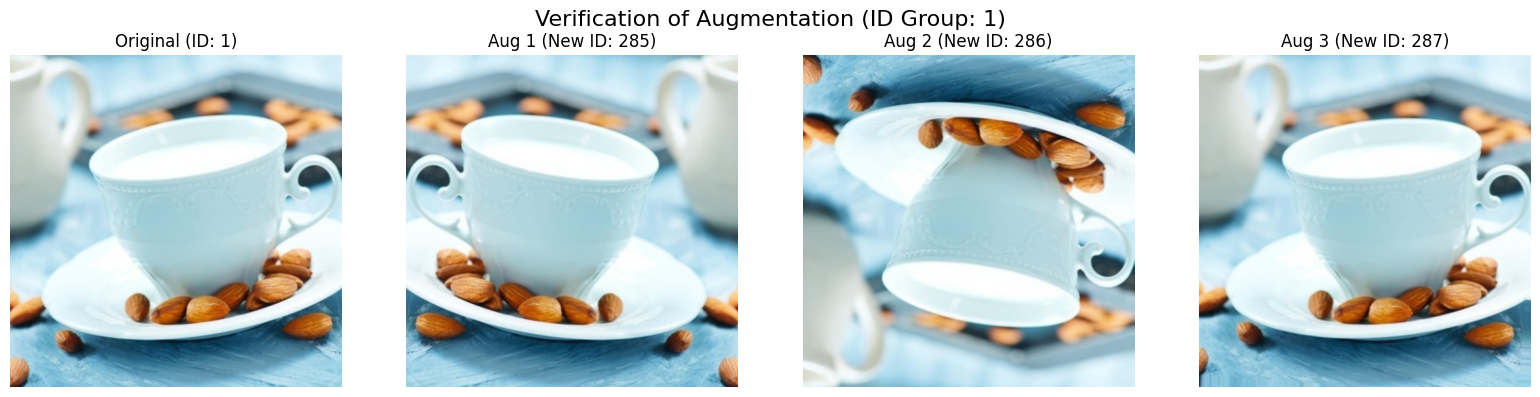

In [17]:

print("\n--- VERIFICATION CHECK: First Augmented Sample ---")

# The original metadata rows are at the start
original_row_meta = final_dataset_df.iloc[0]

# The augmented rows start immediately after the original set
start_index = len(metadata_df)
# Select the first three augmented rows for verification
aug_rows = final_dataset_df.iloc[start_index:start_index + 3].copy()

# --- Display Data ---
print("\n[ORIGINAL IMAGE METADATA]")
# Displaying the path that points back to the original clean image folder
print(original_row_meta[['image_file', 'dish_name', 'classifications_std_list']].to_string())

print("\n[AUGMENTED IMAGES METADATA] (Note: image_file column now shows the new JPEG path)")
# Displaying the path that points to the new augmented JPEG file
print(aug_rows[['image_file', 'dish_name', 'image_id']].to_string(index=False)) # Added 'image_id' to show unique IDs


# --- Display Images ---
if verification_done:
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    fig.suptitle(f"Verification of Augmentation (ID Group: {original_row_meta['image_id']})", fontsize=16)

    # Display original (index 0 in the verification list)
    axes[0].imshow(X_verification_samples[0])
    axes[0].set_title(f"Original (ID: {original_row_meta['image_id']})")
    axes[0].axis('off')

    # Display 3 augmented versions (index 1, 2, 3 in the verification list)
    for i, (ax, img, row) in enumerate(zip(axes[1:], X_verification_samples[1:], aug_rows.itertuples())):
        # Convert back to uint8 for matplotlib display (since NPY is float[0,1])
        ax.imshow(img)
        # The title shows the augmentation type extracted from the new image_file path
        title_parts = os.path.basename(row.image_file).split('.')[0]
        ax.set_title(f"Aug {i+1} (New ID: {row.image_id})")
        ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("\nVerification plot skipped: Insufficient images processed to display sample.")